Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2601 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 65s 643ms/step - accuracy: 0.5184 - loss: 0.7645 - val_accuracy: 0.7000 - val_loss: 0.7314 - learning_rate: 0.0010
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 545ms/step - accuracy: 0.5681 - loss: 0.7442 - val_accuracy: 0.6600 - val_loss: 0.7069 - learning_rate: 0.0010
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 541ms/step - accuracy: 0.6163 - loss: 0.7260 - val_accuracy: 0.6800 - val_loss: 0.6763 - learning_rate: 0.0010
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 526ms/step - accuracy: 0.6417 - loss: 0.7042 - val_accuracy: 0.7000 - val_loss: 0.6490 - learning_rate: 0.0010
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 526ms/step - accuracy: 0.6615 - loss: 0.6879 - val_accuracy: 0.6900 - val_loss: 0.6450 - lear

🔥 Final Training Accuracy: 69.70%
📊 Final Validation Accuracy: 67.00%
🧪 Final Testing Accuracy: 69.33%
❗ Final Loss: 0.6300
✅ Model Saved Successfully in H5 Format!


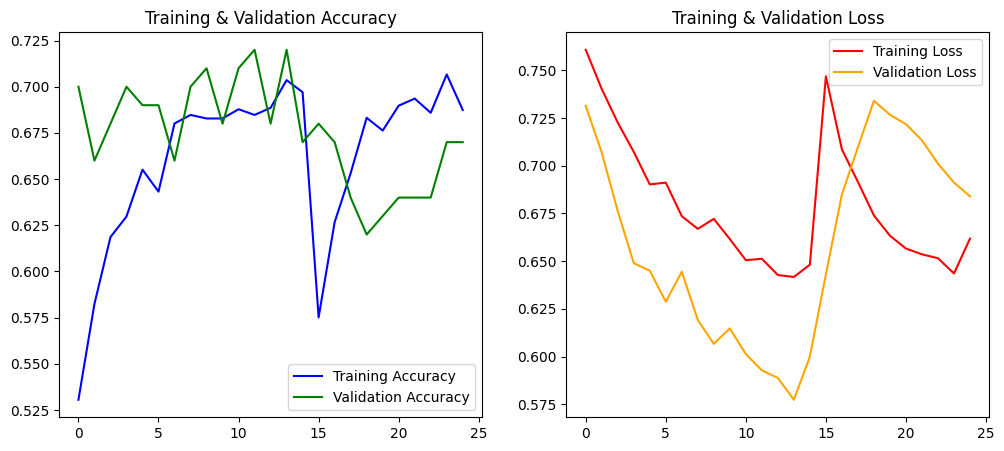

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Dataset Paths
train_dir = "/content/drive/MyDrive/D2/train"
val_dir = "/content/drive/MyDrive/D2/valid"
test_dir = "/content/drive/MyDrive/D2/test"

# ✅ Data Augmentation (Improved)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    channel_shift_range=50.0
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# ✅ Data Loaders (Batch Size Increased)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

# ✅ Load MobileNetV2 (Pretrained)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze entire model initially

# ✅ Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.00005))(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.00005))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.00005))(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.00005))(x)
predictions = Dense(1, activation="sigmoid")(x)

# ✅ Final Model
model = Model(inputs=base_model.input, outputs=predictions)

# ✅ Compile Model (Using SGD w/ Momentum)
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss="binary_crossentropy", metrics=["accuracy"])

# ✅ Learning Rate Adjustment
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# ✅ Initial Training (Feature Extraction)
history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[lr_callback])

# ✅ Unfreeze Last 50 Layers for Fine-Tuning
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# ✅ Re-Compile for Fine-Tuning
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss="binary_crossentropy", metrics=["accuracy"])

# ✅ Fine-Tuning (Unfrozen Layers)
history_finetune = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[lr_callback])

# ✅ Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_generator)

# ✅ Print Final Results
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"🔥 Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"📊 Final Validation Accuracy: {val_acc * 100:.2f}%")
print(f"🧪 Final Testing Accuracy: {test_acc * 100:.2f}%")
print(f"❗ Final Loss: {test_loss:.4f}")

# ✅ Save Improved Model
model.save("/content/drive/MyDrive/mobilenetv2_autism_model_improved_v2.h5")
print("✅ Model Saved Successfully in H5 Format!")

# ✅ Plot Training History
def plot_training_history(history, history_finetune):
    acc = history.history['accuracy'] + history_finetune.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
    loss = history.history['loss'] + history_finetune.history['loss']
    val_loss = history.history['val_loss'] + history_finetune.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='red')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.show()

plot_training_history(history, history_finetune)


In [ ]:
train_size = train_generator.samples
val_size = val_generator.samples
test_size = test_generator.samples

print(f"Training Samples: {train_size}")
print(f"Validation Samples: {val_size}")
print(f"Testing Samples: {test_size}")

Training Samples: 2601
Validation Samples: 100
Testing Samples: 300
